# Project 13: Tokenization and Text Preprocessing

## Goal
Understand how text becomes data for transformers.

## Learning Objectives
- Character-level vs subword tokenization
- Byte-pair encoding (BPE)
- Special tokens (BOS, EOS, PAD, UNK)
- Creating data loaders

In [1]:
# Setup
import numpy as np
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader

print("Ready to explore tokenization!")

Ready to explore tokenization!


In [2]:
# 1) Sample text corpus
corpus = """
The quick brown fox jumps over the lazy dog.
Machine learning models require lots of data.
Transformers use attention mechanisms to process sequences.
Natural language processing is fascinating.
Deep learning has revolutionized AI.
"""

print("Sample corpus:")
print(corpus)
print(f"\nCorpus length: {len(corpus)} characters")
print(f"Unique characters: {len(set(corpus))}")

Sample corpus:

The quick brown fox jumps over the lazy dog.
Machine learning models require lots of data.
Transformers use attention mechanisms to process sequences.
Natural language processing is fascinating.
Deep learning has revolutionized AI.


Corpus length: 233 characters
Unique characters: 35


In [3]:
# 2) Character-Level Tokenization
class CharTokenizer:
    def __init__(self, corpus):
        # Build vocabulary from unique characters
        chars = sorted(list(set(corpus)))
        self.vocab_size = len(chars)
        self.char_to_id = {ch: i for i, ch in enumerate(chars)}
        self.id_to_char = {i: ch for i, ch in enumerate(chars)}
        
    def encode(self, text):
        """Convert text to list of token IDs"""
        return [self.char_to_id[ch] for ch in text if ch in self.char_to_id]
    
    def decode(self, ids):
        """Convert token IDs back to text"""
        return ''.join([self.id_to_char[i] for i in ids])

# Create tokenizer
char_tokenizer = CharTokenizer(corpus)
print(f"Character vocabulary size: {char_tokenizer.vocab_size}")
print(f"Vocabulary: {list(char_tokenizer.char_to_id.keys())[:20]}...")

# Test encoding/decoding
test_text = "Hello transformers!"
encoded = char_tokenizer.encode(test_text)
decoded = char_tokenizer.decode(encoded)

print(f"\nOriginal: {test_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Character vocabulary size: 35
Vocabulary: ['\n', ' ', '.', 'A', 'D', 'I', 'M', 'N', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']...

Original: Hello transformers!
Encoded: [13, 20, 20, 23, 1, 28, 26, 9, 22, 27, 14, 23, 26, 21, 13, 26, 27]
Decoded: ello transformers


In [4]:
# 3) Byte-Pair Encoding (BPE) from Scratch
class SimpleBPE:
    def __init__(self, num_merges=50):
        self.num_merges = num_merges
        self.merges = {}
        self.vocab = {}
        
    def get_stats(self, words):
        """Count frequency of adjacent pairs"""
        pairs = Counter()
        for word in words:
            for i in range(len(word) - 1):
                pairs[word[i], word[i+1]] += 1
        return pairs
    
    def merge_pair(self, pair, words):
        """Merge most frequent pair in all words"""
        new_words = []
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        
        for word in words:
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and word[i] == pair[0] and word[i+1] == pair[1]:
                    new_word.append(replacement)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_words.append(tuple(new_word))
        return new_words
    
    def train(self, text):
        """Train BPE on text corpus"""
        # Start with character-level tokens
        words = [tuple(word + '</w>') for word in text.split()]
        
        # Build initial vocabulary
        self.vocab = Counter()
        for word in words:
            for char in word:
                self.vocab[char] = self.vocab.get(char, 0) + 1
        
        # Perform merges
        for i in range(self.num_merges):
            pairs = self.get_stats(words)
            if not pairs:
                break
            
            best_pair = max(pairs, key=pairs.get)
            self.merges[best_pair] = ''.join(best_pair)
            words = self.merge_pair(best_pair, words)
            
            # Update vocab
            merged_token = ''.join(best_pair)
            self.vocab[merged_token] = pairs[best_pair]
            
            if i < 5:  # Show first few merges
                print(f"Merge {i+1}: {best_pair} → {merged_token} (freq: {pairs[best_pair]})")
        
        print(f"\nTotal vocabulary size: {len(self.vocab)}")
        return self.vocab

# Train BPE
bpe = SimpleBPE(num_merges=30)
vocab = bpe.train(corpus.lower())

print(f"\nTop 20 tokens by frequency:")
for token, freq in sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  '{token}': {freq}")

Merge 1: ('<', '/') → </ (freq: 33)
Merge 2: ('</', 'w') → </w (freq: 33)
Merge 3: ('</w', '>') → </w> (freq: 33)
Merge 4: ('s', '</w>') → s</w> (freq: 8)
Merge 5: ('e', '</w>') → e</w> (freq: 6)

Total vocabulary size: 60

Top 20 tokens by frequency:
  'w': 34
  '<': 33
  '/': 33
  '>': 33
  '</': 33
  '</w': 33
  '</w>': 33
  'e': 23
  'n': 17
  's': 17
  'a': 17
  'i': 14
  'o': 14
  'r': 13
  't': 12
  'u': 8
  'l': 8
  's</w>': 8
  'c': 7
  'g': 7


In [6]:
# 4) Special Tokens
class TokenizerWithSpecials:
    def __init__(self, corpus):
        # Special tokens
        self.BOS = '<BOS>'  # Beginning of sequence
        self.EOS = '<EOS>'  # End of sequence
        self.PAD = '<PAD>'  # Padding
        self.UNK = '<UNK>'  # Unknown token
        
        # Build vocabulary with special tokens first
        special_tokens = [self.PAD, self.UNK, self.BOS, self.EOS]
        chars = sorted(list(set(corpus)))
        all_tokens = special_tokens + chars
        
        self.vocab_size = len(all_tokens)
        self.token_to_id = {tok: i for i, tok in enumerate(all_tokens)}
        self.id_to_token = {i: tok for i, tok in enumerate(all_tokens)}
        
        # Special token IDs
        self.pad_id = self.token_to_id[self.PAD]
        self.unk_id = self.token_to_id[self.UNK]
        self.bos_id = self.token_to_id[self.BOS]
        self.eos_id = self.token_to_id[self.EOS]
        
    def encode(self, text, add_special=True):
        """Encode text with optional special tokens"""
        ids = [self.token_to_id.get(ch, self.unk_id) for ch in text]
        if add_special:
            ids = [self.bos_id] + ids + [self.eos_id]
        return ids
    
    def decode(self, ids, skip_special=True):
        """Decode token IDs to text"""
        special_ids = {self.pad_id, self.bos_id, self.eos_id}
        tokens = []
        for i in ids:
            if skip_special and i in special_ids:
                continue
            tokens.append(self.id_to_token.get(i, self.UNK))
        return ''.join(tokens)
    
    def pad_sequence(self, ids, max_len):
        """Pad sequence to max_len"""
        if len(ids) < max_len:
            ids = ids + [self.pad_id] * (max_len - len(ids))
        else:
            ids = ids[:max_len]
        return ids

# Test tokenizer with special tokens
tokenizer = TokenizerWithSpecials(corpus)
print(f"Vocabulary size (with specials): {tokenizer.vocab_size}")
print(f"Special tokens:")
print(f"  PAD: {tokenizer.pad_id}, UNK: {tokenizer.unk_id}")
print(f"  BOS: {tokenizer.bos_id}, EOS: {tokenizer.eos_id}")

# Test encoding with special tokens
text = "Hello!"
encoded = tokenizer.encode(text, add_special=True)
decoded = tokenizer.decode(encoded, skip_special=True)

print(f"\nText: {text}")
print(f"Encoded (with BOS/EOS): {encoded}")
print(f"Decoded: {decoded}")

# Test padding
padded = tokenizer.pad_sequence(encoded, max_len=15)
print(f"Padded to 15: {padded}")

Vocabulary size (with specials): 39
Special tokens:
  PAD: 0, UNK: 1
  BOS: 2, EOS: 3

Text: Hello!
Encoded (with BOS/EOS): [2, 1, 17, 24, 24, 27, 1, 3]
Decoded: <UNK>ello<UNK>
Padded to 15: [2, 1, 17, 24, 24, 27, 1, 3, 0, 0, 0, 0, 0, 0, 0]


=== Character-Level Tokenization ===
Original text length: 71
Number of tokens: 71
Vocabulary size: 35
Compression ratio: 1.00

=== Subword (BPE) Tokenization ===
Vocabulary size: 60
Note: BPE creates multi-character tokens, reducing sequence length
Example BPE tokens: 'the', 'er', 'ing', 'tion' (common subwords)


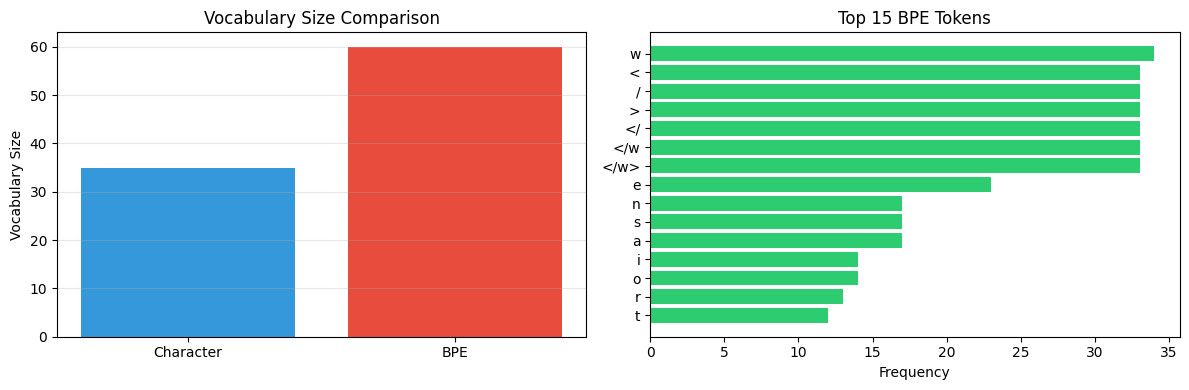

In [7]:
# 5) Comparison: Character vs BPE
import matplotlib.pyplot as plt

# Compare on sample text
sample = "The transformer architecture revolutionized natural language processing"

# Character tokenization
char_tokens = char_tokenizer.encode(sample)
char_compression = len(sample) / len(char_tokens)

print("=== Character-Level Tokenization ===")
print(f"Original text length: {len(sample)}")
print(f"Number of tokens: {len(char_tokens)}")
print(f"Vocabulary size: {char_tokenizer.vocab_size}")
print(f"Compression ratio: {char_compression:.2f}")

print("\n=== Subword (BPE) Tokenization ===")
print(f"Vocabulary size: {len(vocab)}")
print("Note: BPE creates multi-character tokens, reducing sequence length")
print("Example BPE tokens: 'the', 'er', 'ing', 'tion' (common subwords)")

# Visualize vocabulary sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Vocab size comparison
methods = ['Character', 'BPE']
sizes = [char_tokenizer.vocab_size, len(vocab)]
ax1.bar(methods, sizes, color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Vocabulary Size')
ax1.set_title('Vocabulary Size Comparison')
ax1.grid(axis='y', alpha=0.3)

# Token frequency distribution (BPE)
top_tokens = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:15]
tokens, freqs = zip(*top_tokens)
ax2.barh(range(len(tokens)), freqs, color='#2ecc71')
ax2.set_yticks(range(len(tokens)))
ax2.set_yticklabels([t[:10] for t in tokens])
ax2.set_xlabel('Frequency')
ax2.set_title('Top 15 BPE Tokens')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [8]:
# 6) Real-World Tokenizer: HuggingFace GPT-2 BPE
try:
    from transformers import GPT2Tokenizer
    
    # Load pretrained GPT-2 tokenizer
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    
    print("=== GPT-2 Tokenizer ===")
    print(f"Vocabulary size: {len(gpt2_tokenizer)}")
    print(f"Special tokens: {gpt2_tokenizer.special_tokens_map}")
    
    # Test tokenization
    text = "The transformer architecture revolutionized natural language processing!"
    tokens = gpt2_tokenizer.tokenize(text)
    token_ids = gpt2_tokenizer.encode(text)
    
    print(f"\nOriginal text: {text}")
    print(f"Tokens: {tokens}")
    print(f"Token IDs: {token_ids}")
    print(f"Number of tokens: {len(tokens)}")
    
    # Show encoding of specific words
    words = ["transformer", "attention", "language", "revolutionized"]
    print(f"\nSubword breakdown:")
    for word in words:
        word_tokens = gpt2_tokenizer.tokenize(word)
        print(f"  '{word}' → {word_tokens}")
    
    # Decode back
    decoded = gpt2_tokenizer.decode(token_ids)
    print(f"\nDecoded: {decoded}")
    
except ImportError:
    print("transformers library not installed. Install with: pip install transformers")
    print("\nGPT-2 uses BPE with ~50K vocab size")
    print("Special tokens: <|endoftext|> for BOS/EOS")
    print("Handles rare words by breaking into subwords")

=== GPT-2 Tokenizer ===
Vocabulary size: 50257
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}

Original text: The transformer architecture revolutionized natural language processing!
Tokens: ['The', 'Ġtransformer', 'Ġarchitecture', 'Ġrevolution', 'ized', 'Ġnatural', 'Ġlanguage', 'Ġprocessing', '!']
Token IDs: [464, 47385, 10959, 5854, 1143, 3288, 3303, 7587, 0]
Number of tokens: 9

Subword breakdown:
  'transformer' → ['trans', 'former']
  'attention' → ['att', 'ention']
  'language' → ['language']
  'revolutionized' → ['revolution', 'ized']

Decoded: The transformer architecture revolutionized natural language processing!


In [9]:
# 7) Create PyTorch Dataset for Language Modeling
class TextDataset(Dataset):
    def __init__(self, text, tokenizer, block_size=32):
        """
        Create dataset for next-token prediction
        
        Args:
            text: Input text corpus
            tokenizer: Tokenizer with encode method
            block_size: Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.block_size = block_size
        
        # Tokenize entire corpus
        self.tokens = tokenizer.encode(text, add_special=False)
        print(f"Total tokens in corpus: {len(self.tokens)}")
        
    def __len__(self):
        # Number of possible blocks
        return max(0, len(self.tokens) - self.block_size)
    
    def __getitem__(self, idx):
        # Get block of tokens
        chunk = self.tokens[idx:idx + self.block_size + 1]
        
        # Input and target (shifted by 1)
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        
        return x, y

# Create dataset and dataloader
dataset = TextDataset(corpus, tokenizer, block_size=16)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset size: {len(dataset)} sequences")
print(f"Batch size: 4")
print(f"Number of batches: {len(dataloader)}")

# Show sample batch
batch_x, batch_y = next(iter(dataloader))
print(f"\nSample batch shapes:")
print(f"  Input (x): {batch_x.shape}")
print(f"  Target (y): {batch_y.shape}")

# Decode first sample
print(f"\nFirst sample in batch:")
print(f"  Input tokens: {batch_x[0].tolist()}")
print(f"  Target tokens: {batch_y[0].tolist()}")
print(f"  Input text: {tokenizer.decode(batch_x[0].tolist(), skip_special=True)}")
print(f"  Target text: {tokenizer.decode(batch_y[0].tolist(), skip_special=True)}")

Total tokens in corpus: 233
Dataset size: 217 sequences
Batch size: 4
Number of batches: 55

Sample batch shapes:
  Input (x): torch.Size([4, 16])
  Target (y): torch.Size([4, 16])

First sample in batch:
  Input tokens: [33, 25, 28, 31, 5, 27, 34, 17, 30, 5, 32, 20, 17, 5, 24, 13]
  Target tokens: [25, 28, 31, 5, 27, 34, 17, 30, 5, 32, 20, 17, 5, 24, 13, 38]
  Input text: umps over the la
  Target text: mps over the laz


In [10]:
# 8) Batching with Padding (Variable Length Sequences)
def collate_batch(batch):
    """
    Collate function for DataLoader to handle variable-length sequences
    Pads sequences to max length in batch
    """
    xs, ys = zip(*batch)
    
    # Find max length in batch
    max_len = max(len(x) for x in xs)
    
    # Pad sequences
    pad_id = tokenizer.pad_id
    xs_padded = torch.stack([
        torch.cat([x, torch.full((max_len - len(x),), pad_id, dtype=torch.long)])
        if len(x) < max_len else x
        for x in xs
    ])
    ys_padded = torch.stack([
        torch.cat([y, torch.full((max_len - len(y),), pad_id, dtype=torch.long)])
        if len(y) < max_len else y
        for y in ys
    ])
    
    # Create attention mask (1 for real tokens, 0 for padding)
    attention_mask = (xs_padded != pad_id).long()
    
    return xs_padded, ys_padded, attention_mask

# Test collate function
dataloader_padded = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)
batch_x, batch_y, mask = next(iter(dataloader_padded))

print("Batching with dynamic padding:")
print(f"  Input shape: {batch_x.shape}")
print(f"  Target shape: {batch_y.shape}")
print(f"  Attention mask shape: {mask.shape}")
print(f"\nAttention mask (1=real token, 0=padding):")
print(mask.numpy())

Batching with dynamic padding:
  Input shape: torch.Size([4, 16])
  Target shape: torch.Size([4, 16])
  Attention mask shape: torch.Size([4, 16])

Attention mask (1=real token, 0=padding):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [11]:
# 9) Save Tokenizer
import json
from pathlib import Path

out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

# Save vocabulary
vocab_dict = {
    'token_to_id': tokenizer.token_to_id,
    'id_to_token': tokenizer.id_to_token,
    'special_tokens': {
        'PAD': tokenizer.pad_id,
        'UNK': tokenizer.unk_id,
        'BOS': tokenizer.bos_id,
        'EOS': tokenizer.eos_id
    },
    'vocab_size': tokenizer.vocab_size
}

with open(out_dir / 'tokenizer_vocab.json', 'w') as f:
    json.dump(vocab_dict, f, indent=2)

print(f"Saved tokenizer vocabulary to: {out_dir / 'tokenizer_vocab.json'}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"\nTo load:")
print("```python")
print("import json")
print("with open('data/processed/tokenizer_vocab.json') as f:")
print("    vocab = json.load(f)")
print("```")

Saved tokenizer vocabulary to: data/processed/tokenizer_vocab.json
Vocabulary size: 39

To load:
```python
import json
with open('data/processed/tokenizer_vocab.json') as f:
    vocab = json.load(f)
```


In [12]:
# 10) Summary & Key Concepts
from IPython.display import Markdown, display
display(Markdown(r'''
## Summary: Tokenization for Transformers

### What We Learned

**1. Character-Level Tokenization**
- Simplest approach: each character is a token
- Small vocabulary (26 letters + punctuation + space ≈ 50-100 tokens)
- Long sequences (every character is a token)
- Good for: character-level tasks, small alphabets
- Bad for: long sequences, large vocabularies

**2. Byte-Pair Encoding (BPE)**
- Iteratively merges most frequent character pairs
- Creates subword vocabulary (common prefixes/suffixes)
- Balances vocab size vs sequence length
- Used by: GPT-2, GPT-3, RoBERTa
- Advantages:
  - Handles rare words by breaking into subwords
  - No unknown tokens (can always fall back to characters)
  - Compression: fewer tokens than character-level

**3. Special Tokens**
- `<PAD>`: Padding for batch processing
- `<UNK>`: Unknown/out-of-vocabulary tokens
- `<BOS>`: Beginning of sequence
- `<EOS>`: End of sequence
- Model learns to recognize and use these appropriately

**4. Data Preparation**
- **Encoding**: Text → Token IDs (integers)
- **Decoding**: Token IDs → Text
- **Padding**: Ensure equal length in batches
- **Attention Mask**: Mark real vs padded tokens

### Tokenization Comparison

| Method | Vocab Size | Seq Length | Use Case |
|--------|-----------|------------|----------|
| Character | ~50-100 | Very Long | Simple, small data |
| BPE | ~5K-50K | Moderate | General purpose (GPT) |
| WordPiece | ~30K | Moderate | BERT, Transformers |
| SentencePiece | ~32K | Moderate | Multilingual (T5) |

### BPE Algorithm Steps

1. Start with character vocabulary
2. Count all adjacent character pairs
3. Merge most frequent pair into new token
4. Update vocabulary
5. Repeat for N iterations
6. Result: vocabulary of characters + common subwords

### PyTorch DataLoader Pattern

```python
# 1. Create Dataset
dataset = TextDataset(text, tokenizer, block_size=512)

# 2. Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_batch  # handles padding
)

# 3. Training loop
for batch_x, batch_y, mask in dataloader:
    logits = model(batch_x, mask)
    loss = F.cross_entropy(logits.view(-1, vocab_size), batch_y.view(-1))
    loss.backward()
```

### Best Practices

1. **Choose tokenizer based on task**:
   - Character: very small data, character-level modeling
   - BPE/WordPiece: most NLP tasks
   - SentencePiece: multilingual

2. **Vocabulary size trade-offs**:
   - Larger vocab → shorter sequences → faster
   - Smaller vocab → longer sequences → more context
   - Typical: 5K-50K tokens

3. **Handle special tokens consistently**:
   - Always reserve IDs 0-3 for PAD, UNK, BOS, EOS
   - Include special tokens during training
   - Model learns their meaning

4. **Batching strategies**:
   - Fixed-length: pad to max_len (wasteful but simple)
   - Dynamic: pad to max in batch (efficient)
   - Bucketing: group similar-length sequences

5. **Attention masks**:
   - 1 for real tokens, 0 for padding
   - Model ignores padded positions
   - Essential for variable-length sequences

### Real-World Tokenizers

- **GPT-2/3**: BPE with ~50K vocab
- **BERT**: WordPiece with ~30K vocab
- **T5**: SentencePiece with ~32K vocab
- **LLaMA**: SentencePiece with ~32K vocab

### Key Takeaways

✅ Tokenization converts text to integers for model input  
✅ BPE balances vocab size and sequence length  
✅ Special tokens handle edge cases (padding, unknown)  
✅ DataLoaders handle batching and padding automatically  
✅ Attention masks distinguish real vs padded tokens  
✅ Same tokenizer must be used for training and inference  

### Next Steps

- **Project 14**: Train transformer on tokenized data
- **Project 15**: Compare random vs pretrained models
- Experiment with different vocab sizes
- Try multilingual tokenization (SentencePiece)
'''))


## Summary: Tokenization for Transformers

### What We Learned

**1. Character-Level Tokenization**
- Simplest approach: each character is a token
- Small vocabulary (26 letters + punctuation + space ≈ 50-100 tokens)
- Long sequences (every character is a token)
- Good for: character-level tasks, small alphabets
- Bad for: long sequences, large vocabularies

**2. Byte-Pair Encoding (BPE)**
- Iteratively merges most frequent character pairs
- Creates subword vocabulary (common prefixes/suffixes)
- Balances vocab size vs sequence length
- Used by: GPT-2, GPT-3, RoBERTa
- Advantages:
  - Handles rare words by breaking into subwords
  - No unknown tokens (can always fall back to characters)
  - Compression: fewer tokens than character-level

**3. Special Tokens**
- `<PAD>`: Padding for batch processing
- `<UNK>`: Unknown/out-of-vocabulary tokens
- `<BOS>`: Beginning of sequence
- `<EOS>`: End of sequence
- Model learns to recognize and use these appropriately

**4. Data Preparation**
- **Encoding**: Text → Token IDs (integers)
- **Decoding**: Token IDs → Text
- **Padding**: Ensure equal length in batches
- **Attention Mask**: Mark real vs padded tokens

### Tokenization Comparison

| Method | Vocab Size | Seq Length | Use Case |
|--------|-----------|------------|----------|
| Character | ~50-100 | Very Long | Simple, small data |
| BPE | ~5K-50K | Moderate | General purpose (GPT) |
| WordPiece | ~30K | Moderate | BERT, Transformers |
| SentencePiece | ~32K | Moderate | Multilingual (T5) |

### BPE Algorithm Steps

1. Start with character vocabulary
2. Count all adjacent character pairs
3. Merge most frequent pair into new token
4. Update vocabulary
5. Repeat for N iterations
6. Result: vocabulary of characters + common subwords

### PyTorch DataLoader Pattern

```python
# 1. Create Dataset
dataset = TextDataset(text, tokenizer, block_size=512)

# 2. Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_batch  # handles padding
)

# 3. Training loop
for batch_x, batch_y, mask in dataloader:
    logits = model(batch_x, mask)
    loss = F.cross_entropy(logits.view(-1, vocab_size), batch_y.view(-1))
    loss.backward()
```

### Best Practices

1. **Choose tokenizer based on task**:
   - Character: very small data, character-level modeling
   - BPE/WordPiece: most NLP tasks
   - SentencePiece: multilingual

2. **Vocabulary size trade-offs**:
   - Larger vocab → shorter sequences → faster
   - Smaller vocab → longer sequences → more context
   - Typical: 5K-50K tokens

3. **Handle special tokens consistently**:
   - Always reserve IDs 0-3 for PAD, UNK, BOS, EOS
   - Include special tokens during training
   - Model learns their meaning

4. **Batching strategies**:
   - Fixed-length: pad to max_len (wasteful but simple)
   - Dynamic: pad to max in batch (efficient)
   - Bucketing: group similar-length sequences

5. **Attention masks**:
   - 1 for real tokens, 0 for padding
   - Model ignores padded positions
   - Essential for variable-length sequences

### Real-World Tokenizers

- **GPT-2/3**: BPE with ~50K vocab
- **BERT**: WordPiece with ~30K vocab
- **T5**: SentencePiece with ~32K vocab
- **LLaMA**: SentencePiece with ~32K vocab

### Key Takeaways

✅ Tokenization converts text to integers for model input  
✅ BPE balances vocab size and sequence length  
✅ Special tokens handle edge cases (padding, unknown)  
✅ DataLoaders handle batching and padding automatically  
✅ Attention masks distinguish real vs padded tokens  
✅ Same tokenizer must be used for training and inference  

### Next Steps

- **Project 14**: Train transformer on tokenized data
- **Project 15**: Compare random vs pretrained models
- Experiment with different vocab sizes
- Try multilingual tokenization (SentencePiece)
